Click [here](https://medium.com/@morihosseini/data-mastery-polars-unpacked-c9718261aa15) to access the associated Medium article.

# Setup

In [1]:
!pip install -q polars matplotlib

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import random
import string

import matplotlib.pyplot as plt

import polars as pl


SEED = 777  # for reproducibility
plt.style.use("ggplot_classic.mplstyle")  # a custom plot style

# Dataset

In [3]:
# Defining the size of our dataset
size = 1000000

# Setting the seed for reproducibility
random.seed(SEED)

# Creating a DataFrame
age = random.choices(range(20, 40), k=size // 2) + random.choices(
    range(40, 71), k=size - size // 2
)
city = random.choices(
    ["New York", "London", "Paris", "Tokyo"],
    weights=[1.0, 0.9, 0.3, 1.5],
    k=size,
)
is_married = random.choices([True, False], weights=[1.0, 1.5], k=size)
bmi = [round(random.uniform(17.0, 27.0), 2) for _ in range(size)]

df = pl.DataFrame(
    {"age": age, "city": city, "is_married": is_married, "bmi": bmi}
)

## Inspecting the Dataset

In [4]:
df.shape

(1000000, 4)

In [5]:
df.head()

age,city,is_married,bmi
i64,str,bool,f64
24,"""New York""",true,21.84
28,"""Tokyo""",false,24.37
27,"""Tokyo""",false,20.84
25,"""London""",true,24.02
26,"""Paris""",true,25.41


In [6]:
df.describe()

describe,age,city,is_married,bmi
str,f64,str,f64,f64
"""count""",1e6,"""1000000""",1e6,1e6
"""null_count""",0.0,"""0""",0.0,0.0
"""mean""",42.258076,null,0.399538,21.998547
"""std""",14.804733,null,0.489804,2.88818
"""min""",20.0,"""London""",0.0,17.0
"""25%""",30.0,null,null,19.5
"""50%""",40.0,null,null,22.0
"""75%""",55.0,null,null,24.5
"""max""",70.0,"""Tokyo""",1.0,27.0


# Data Cleaning

## Missing Values

In [7]:
# Create some missing data.
# Whenever 'age' is over 68, corresponding 'bmi' becomes 'null'
df = df.with_columns(
    pl.when(pl.col("age") > 68).then(None).otherwise(pl.col("bmi")).alias(
        "bmi"
    )
)

In [8]:
# Counting missing values
df.null_count()

age,city,is_married,bmi
u32,u32,u32,u32
0,0,0,32143


In [9]:
# Imputing missing values with the median of the column 'bmi'
df = df.with_columns(pl.col("bmi").fill_null(pl.median("bmi")))

# Counting missing values again
df.null_count()

age,city,is_married,bmi
u32,u32,u32,u32
0,0,0,0


## Type Casting

In [10]:
# Casting 'bmi' to integer (show only).
df.select(pl.col("bmi").cast(pl.Int32)).head()

bmi
i32
21
24
20
24
25


In [11]:
# Original 'bmi'
df.select(pl.col("bmi")).head()

bmi
f64
21.84
24.37
20.84
24.02
25.41


## Creating New Columns

In [12]:
# Create a new column 'age_in_months' (show only)
df.with_columns((pl.col("age") * 12).alias("age_in_months")).head()

age,city,is_married,bmi,age_in_months
i64,str,bool,f64,i64
24,"""New York""",true,21.84,288
28,"""Tokyo""",false,24.37,336
27,"""Tokyo""",false,20.84,324
25,"""London""",true,24.02,300
26,"""Paris""",true,25.41,312


## Removing Duplicates

In [13]:
# Save only unique values in the dataset
df = df.unique()

# Data Visualization

In [14]:
# Sample 1000 rows from the dataset
sample_df = df.sample(1000, seed=SEED)

## Histogram

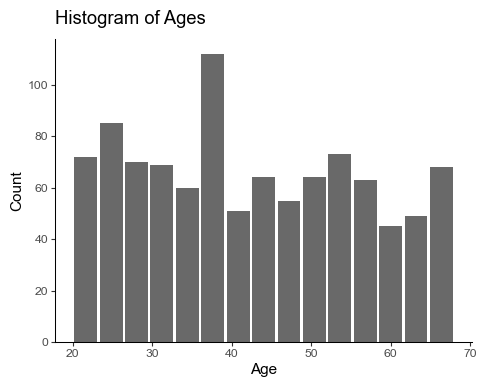

In [15]:
# Create a figure
plt.figure(figsize=(5, 4), layout="tight")

# Plot
plt.hist(sample_df["age"], bins=15, rwidth=0.9, color="dimgray")

# Add a title and axis labels
plt.title("Histogram of Ages")
plt.xlabel("Age")
plt.ylabel("Count")

# Save the plot
# plt.savefig("histogram.png", dpi=120)

# Show the plot
plt.show()

## Box Plot

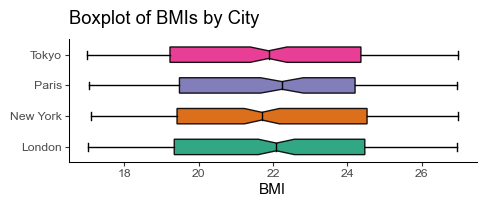

In [16]:
# Create a figure
plt.figure(figsize=(5, 2.2), layout="tight")

# Plot
cities_list = sample_df["city"].unique().sort().to_list()

bplot = plt.boxplot(
    [sample_df.filter(pl.col("city") == ct)["bmi"] for ct in cities_list],
    notch=True,
    labels=cities_list,
    vert=False,
    widths=0.5,
    patch_artist=True,
)

for i, color in enumerate(plt.cm.Dark2.colors[: len(cities_list)]):
    bplot["boxes"][i].set(facecolor=color, alpha=0.9)
    bplot["medians"][i].set(color="black")

# Add a title and axis labels
plt.title("Boxplot of BMIs by City")
plt.xlabel("BMI")

# Save the plot
# plt.savefig("boxplot.png", dpi=110)

# Show the plot
plt.show()

## Scatter Plot

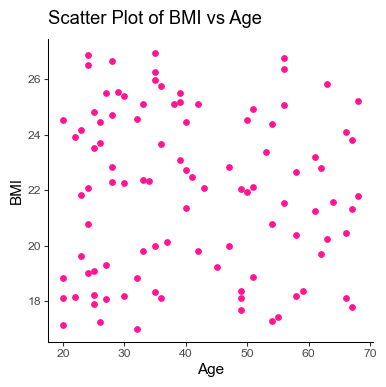

In [17]:
# Create a figure
plt.figure(figsize=(4, 4), layout="tight")

# Plot
plt.scatter(sample_df["age"][:100], sample_df["bmi"][:100], color="deeppink", s=15)

# Add a title and axis labels
plt.title("Scatter Plot of BMI vs Age")
plt.xlabel("Age")
plt.ylabel("BMI")

# Save the plot
# plt.savefig("scatter.png", dpi=110)

# Show the plot
plt.show()

## Bar Chart

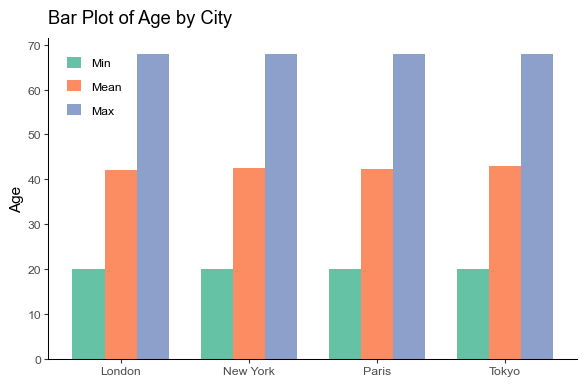

In [18]:
# Create a figure
plt.figure(figsize=(6, 4), layout="tight")

# Plot
grouped_df = (
    sample_df.group_by("city")
    .agg(
        pl.col("age").min().alias("min_age"),
        pl.col("age").mean().alias("mean_age"),
        pl.col("age").max().alias("max_age"),
    )
    .sort("city")
)

cities_list = grouped_df["city"].to_list()

bar_width = 0.25
_width = [-bar_width, 0, bar_width]
_column = ["min_age", "mean_age", "max_age"]
_label = ["Min", "Mean", "Max"]

for i, (width, column, label) in enumerate(zip(_width, _column, _label)):
    plt.bar(
        [x + width for x in range(len(cities_list))],
        grouped_df[column],
        width=bar_width,
        label=label,
        color=plt.cm.Set2.colors[i],
    )

# Add a title and axis labels
plt.xticks(range(len(cities_list)), cities_list)
plt.title("Bar Plot of Age by City")
plt.ylabel("Age")
plt.legend(loc="upper left")

# Save the plot
# plt.savefig("barplot.png", dpi=100)

# Show the plot
plt.show()

# Descriptive Statistics and Insights

## Mean, Median, and Standard Deviation

In [19]:
# Mean
mean_age = df["age"].mean()
print(f"Average age is {mean_age:.2f}")

# Median
median_age = df["age"].median()
print(f"Median age is {median_age}")

# Standard deviation
std_age = df["age"].std()
print(f"Standard deviation of age is {std_age:.2f}")

Average age is 43.34
Median age is 43.0
Standard deviation of age is 14.20


## Correlation

In [20]:
df.select(pl.corr("age", "bmi").alias("correlation"))

correlation
f64
0.000631


# Advanced EDA Techniques

## Grouping Data

In [21]:
df.group_by("city").agg(
    [
        pl.col("age").mean().alias("average_age"),
        pl.col("bmi").median().alias("median_bmi"),
    ]
)

city,average_age,median_bmi
str,f64,f64
"""London""",43.368799,22.01
"""Paris""",42.299786,22.0
"""Tokyo""",43.775188,22.0
"""New York""",43.479802,22.0


## Apply Custom Functions

In [22]:
def age_group(age):
    if age < 30:
        return "Young"
    elif age < 60:
        return "Adult"
    else:
        return "Senior"


df.with_columns(
    pl.col("age").map_elements(age_group).alias("age_group")
).head()

age,city,is_married,bmi,age_group
i64,str,bool,f64,str
33,"""Tokyo""",true,19.55,"""Adult"""
20,"""Tokyo""",true,26.15,"""Young"""
30,"""New York""",false,22.84,"""Adult"""
30,"""London""",true,23.15,"""Adult"""
38,"""Tokyo""",false,19.41,"""Adult"""


## Pivot Tables

In [23]:
# Average 'bmi', by 'is_married' and 'city'
df.pivot(
    index="is_married",
    columns="city",
    values="bmi",
    aggregate_function="mean",
)

is_married,Tokyo,New York,London,Paris
bool,f64,f64,f64,f64
true,21.999968,21.992436,22.003721,22.019422
false,21.999371,22.002251,22.001244,21.985739
